In [3]:
# The purpose of this file is to create a price tensor for input into the neural network
# and to train the policy using Deep Deterministic Policy Gradient.
# Code is inspired by the paper "A Deep Reinforcement Learning Framework for the Financial Portfolio Management Problem"
# For more details, see: c.f https://arxiv.org/abs/1706.10059


from typing import List

import torch

from ddpgportfolio.agent.ddpg_agent import DDPGAgent
from ddpgportfolio.dataset import KrakenDataSet
from ddpgportfolio.portfolio.portfolio import Portfolio

torch.set_default_device("mps")



BATCH_SIZE = 50  # training is done in mini-batches
WINDOW_SIZE = 50  # last n timesteps for the price tensor
STEP_SIZE = 1  # for rolling window batch sampler
start_date = "2024-08-01"  # start date of trading
# DEVICE = "mps"

asset_names: List[str] = [
    "CASH",
    "SOL",
    "ADA",
    "USDT",
    "AVAX",
    "LINK",
    "DOT",
    "PEPE",
    "ETH",
    "XRP",
    "TRX",
    "MATIC",
]

portfolio = Portfolio(asset_names=asset_names, start_date=start_date)

agent = DDPGAgent(portfolio, BATCH_SIZE, WINDOW_SIZE, STEP_SIZE, 100)

# need to pretrain the agent to populate the replay buffer with experiences
agent.pre_train()
# train the agent
#agent.train()




pre-training ddpg agent started...
ReplayMemoryBuffer populating with experience...
pretraining done
buffer size: 2876


In [4]:
agent.train()

Training Started for DDPG Agent
Episode 1 - Actor Loss: -0.0752, Critic Loss: 0.0180, Total Reward: -17.9342
Episode 2 - Actor Loss: -0.0783, Critic Loss: 0.0118, Total Reward: -16.0398
Episode 3 - Actor Loss: -0.0783, Critic Loss: 0.0137, Total Reward: -13.2759
Episode 4 - Actor Loss: -0.0771, Critic Loss: 0.0110, Total Reward: -15.1675
Episode 5 - Actor Loss: -0.0790, Critic Loss: 0.0112, Total Reward: -15.1053
Episode 6 - Actor Loss: -0.0821, Critic Loss: 0.0123, Total Reward: -10.4756
Episode 7 - Actor Loss: -0.0735, Critic Loss: 0.0106, Total Reward: -20.4981
Episode 8 - Actor Loss: -0.0790, Critic Loss: 0.0092, Total Reward: -14.6597
Episode 9 - Actor Loss: -0.0801, Critic Loss: 0.0082, Total Reward: -13.5051
Episode 10 - Actor Loss: -0.0818, Critic Loss: 0.0121, Total Reward: -11.8803
Episode 11 - Actor Loss: -0.0770, Critic Loss: 0.0088, Total Reward: -18.7731
Episode 12 - Actor Loss: -0.0775, Critic Loss: 0.0095, Total Reward: -14.5798
Episode 13 - Actor Loss: -0.0745, Critic 

In [102]:
from utilities.noise import plot_equity_curve

In [6]:
equity_curve = plot_equity_curve(agent.pvm);

In [13]:
agent.pvm.get_memory_stack(50) * 10000
noncash_action = agent.pvm.get_memory_stack(49)  # Get action (weights) at this timestep
cash = 1 - noncash_action.sum()
action = torch.cat([cash.unsqueeze(0), noncash_action], dim=0)
portfolio_value = (
    (action * 10000).sum().item()
)  # Portfolio value

In [7]:
import numpy as np
weights = []

In [8]:
ds = KrakenDataSet(portfolio, 50, 1)
portfolio_values = []
pf_previous = 10000
portfolio_values.append(pf_previous)
total_reward = 0

for idx, (Xt, prev_index) in enumerate(ds):
    yt = 1 / Xt[0, :, -2]
    wt_prev = agent.pvm.get_memory_stack(prev_index)
    wt = agent.pvm.get_memory_stack(prev_index + 1)
    weights.append(wt.cpu().numpy())
    reward = portfolio.get_reward(wt, yt, wt_prev)
    total_reward += reward
    pf_current = pf_previous * np.exp(total_reward.item())
    portfolio_values.append(pf_current)
    

In [98]:
def get_random_action(m):
    random_vec = np.random.rand(m+1)
    return random_vec/np.sum(random_vec)

In [11]:
weights[0]

array([8.7769577e-06, 1.0565467e-05, 8.7437065e-06, 1.0191260e-05,
       9.7114271e-06, 9.2239979e-06, 8.4826161e-06, 9.5551595e-06,
       7.1022000e-06, 8.6109067e-06, 9.8383543e-06], dtype=float32)

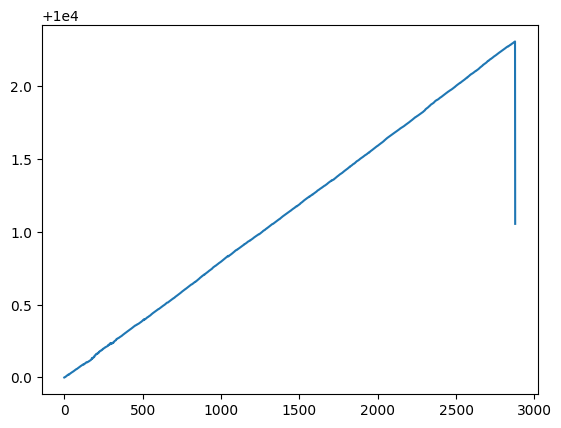

In [9]:
import matplotlib.pyplot as plt
plt.plot(portfolio_values)

In [60]:
cpr = portfolio.get_close_price()

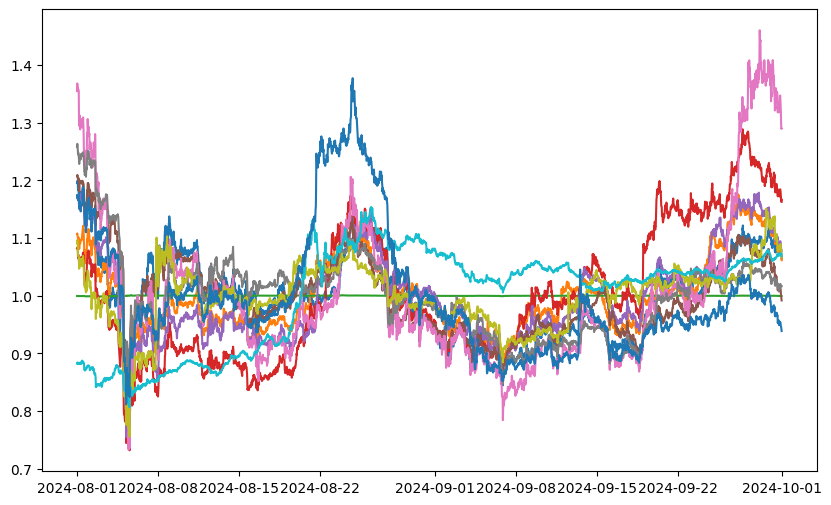

In [64]:
df_normalized = cpr / cpr.mean()
plt.figure(figsize=(10, 6))
for column in df_normalized.columns:
    plt.plot(df_normalized.index, df_normalized[column], label=column);